# Animation along transect

In [1]:
% pylab inline
% matplotlib notebook

from __future__ import print_function
import sys, os
from scipy.interpolate import RegularGridInterpolator
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
from IPython.display import HTML

import data_tools

data_dir = 'data' #/data/CCtimeframes'
# check that directory exists, raise an exception if not:
assert os.path.isdir(data_dir), '*** Data directory not found'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read in topography

anim_topo_file = os.path.join(data_dir,'topo.asc')
anim_topo_data_dict = data_tools.read_asc_file(anim_topo_file, verbose=False)

anim_topo = anim_topo_data_dict['values']
animX = anim_topo_data_dict['X']
animY = anim_topo_data_dict['Y']

# Make available for interpolation
anim_topo_func = RegularGridInterpolator((animX[0,:], animY[:,0]), anim_topo.T)

In [3]:
# Define function to read in depth data frames

def read_animation_frames(frameno, verbose=False):
    time = 2*frameno  # minutes after earthquake
    fname = 'depth_%s.asc' % str(frameno).zfill(4)
    depth_file = os.path.join(data_dir, fname)
    if verbose:
        print("Reading %s at time %s minutes" % (depth_file, time))
        
    depth_data_dict = data_tools.read_asc_file(depth_file, verbose=False)

    depth = depth_data_dict['values']
    zeta = where(anim_topo>0, depth, anim_topo + depth)
    return depth, zeta, time

## Trace through time
Up to now I've mostly stolen code for reading data. Now I want to trace the water surface through many frames along the same line in anticipation of animating them.

In [4]:
# Go through and do interpolations on all the frames once we've chosen a transect

def calc_animation_transect(xprev,xnew,yprev,ynew,nframes):
    
    xi = linspace(xprev, xnew, 1000)
    yi = linspace(yprev, ynew, 1000)
    
    if (abs(xnew-xprev) > 0.5*abs(ynew-yprev)):
        ti = xi
        xtext = 'longitude'
    else:
        ti = yi
        xtext = 'latitude'
    
    # Interpolate the topo
    anim_topo_func = RegularGridInterpolator((animX[0,:], animY[:,0]), anim_topo.T)
    Bi = anim_topo_func(list(zip(xi,yi)))
    
    # In loop, interpolate the depths and calculate eta
    etas = np.empty((nframes, 1000))
    for frameno in range(nframes):
        depth, zeta, time = read_animation_frames(frameno)
        depth_func = RegularGridInterpolator((animX[0,:], animY[:,0]), depth.T)
        zi = depth_func(list(zip(xi,yi)))
        etas[frameno, :] = zi+Bi

    return Bi, etas, ti, xtext


## Create animation
In this example, I'm taking a vertical transect at the middle. I've kept the names similar to the names from the interactive example with the idea that they would be passed along to this function.

The sort of tricky part here is defining the patch in a way that can be animated, thus the whole MOVETO, LINETO, and CLOSEPOLY codes.

In [5]:
def create_animation(Bi, etas, ti, xtext, nframes):

    # Set up the figure
    fig = plt.figure(figsize=(12,3))
    ax = plt.subplot(111)

    # Draw patch for land
    # First define codes that define the start, path, and closing of the patch
    codes_land = [path.Path.MOVETO] + [path.Path.LINETO]*1001 + [path.Path.CLOSEPOLY]
    # Define the vertices in pairs of (x,y)
    vertices_land = [(ti[0], -1e6)] + list(zip(ti,Bi)) + [(ti[-1], -1e6), (0,0)]
    vertices_land = np.array(vertices_land, float)

    # Feed to Path and PathPatch
    path_land = path.Path(vertices_land, codes_land)
    patch_land = patches.PathPatch(path_land, facecolor=[.5,1,.5], edgecolor='none')
    ax.add_patch(patch_land)

    # Draw patch for water between land and surface
    codes_water = [path.Path.MOVETO] + [path.Path.LINETO]*1999 + [path.Path.CLOSEPOLY]
    vertices_water = list(zip(ti,etas[0,:])) + list(zip(ti,Bi))[::-1] + [(0,0)]
    vertices_water = np.array(vertices_water, float)

    path_water = path.Path(vertices_water, codes_water)
    patch_water = patches.PathPatch(path_water, facecolor='b', edgecolor='k')
    ax.add_patch(patch_water)

    # Set zoom limits (very important!)
    ax.set_xlim(ti[0], ti[-1])
    ax.set_ylim(-10, 10)

    # Labels
    ax.set_xlabel(xtext)
    ax.set_ylabel('elevation [m]')

    # Animation updates the vertices corresponding to the water's surface
    def animate(i):
        vertices_water[0:1000, 1] = etas[i,:]
        return [patch_water, ]

    ani = animation.FuncAnimation(fig, animate, nframes, interval=5000/nframes, blit=True)
    
    return ani

<IPython.core.display.Javascript object>


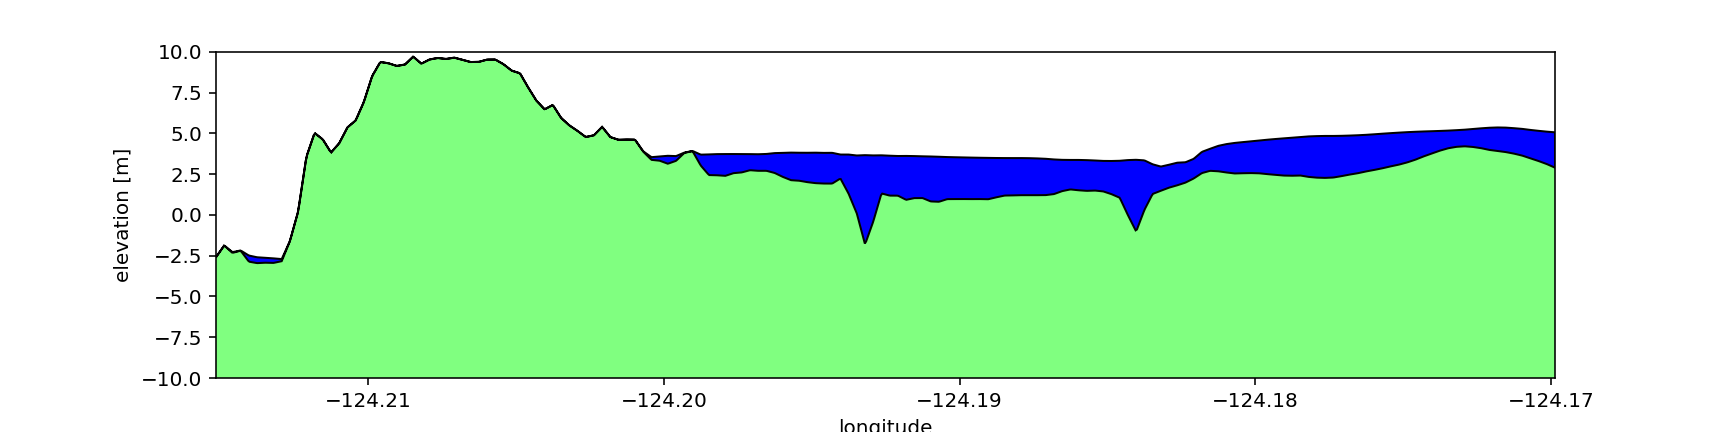

In [6]:
# Calculate the transect
Bi, etas, ti, xtext = calc_animation_transect(np.min(animX), np.max(animX), np.mean(animY), np.mean(animY), 61)

# Run animation
ani = create_animation(Bi, etas, ti, xtext, 61)
